# GEONE - GEOSCLASSIC - categorical variable - non-stationary covariance model

## Estimation (kriging) and simulation (Sequential Indicator Simulation, SIS)

See notebook `ex_geosclassic_indicator_1d_1.ipynb` for detail explanations about estimation (kriging) and simulation (Sequential Indicator Simulation, SIS) in a grid - using stationary covariance model.

## Non-stationary covariance model over a grid
See notebook `ex_geosclassic_1d_2_non_stat_cov.ipynb` for detail explanations on how to set non-stationarities in a grid.


## Examples in 1D
In this notebook, examples in 1D with a non-stationary covariance model are given.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Category values
A list of category values (facies) must be defined. Let `ncategory` be the length of this list, *i.e.* the number of categories:

- if `ncategory == 1`: the unique category value given must not be equal to 0; this is used for a binary case with values ("unique category value", 0), where 0 indicates the absence of the considered medium; conditioning data values should be "unique category value" or 0
- if `ncategory >= 2`: this is used for a multi-category case with given values (distinct); conditioning data values should be in the list of given values

Then, set color for each category, and color maps for proportions (for further plots).

**Below: select the case with `ncategory` greater than one or equal to one below, comment the undesired cell.**

In [3]:
# Case with ncategory > 1
# -----------------------
category_values = [1., 2., 3.]
ncategory = len(category_values)

# Set colors ...
categVal = category_values
categCol = ['lightblue', 'orange', 'darkgreen'] # must be of length len(categVal)
cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]


In [4]:
# # Case with ncategory = 1
# # -----------------------
# category_values = [2.] # all categories are 2. and 0.
# ncategory = len(category_values)

# # Set colors ...
# categVal = [category_values[0], 0]
# categCol = ['tab:red', 'lightblue'] # must be of length len(categVal)
# cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]

## Grid (1D)

In [5]:
nx = 1000  # number of cells
sx = 1.0  # cell unit
ox = 0.0  # origin

## Covariance model

In 1D, a covariance model is given by an instance of the class `geone.covModel.covModel1D`.

### Base covariance model (sationary)
The weight `'w'` to every elementary contribution is set to `1.0`; the method `multiply_w` will be used to set non-stationarities about this parameter.

In [6]:
# Define the base covariance model (stationary)
cov_model = gn.covModel.CovModel1D(elem=[
    ('exponential', {'w':1.0, 'r':100}),  # elementary contribution
    ('nugget', {'w':1.0}),                # elementary contribution
    ], name='model-1D example')


In [7]:
# plt.figure()
# cov_model.plot_model()
# plt.title('Covariance function - base')
# plt.show()

### Defining non-stationarities


In [8]:
# Set an image with grid geometry defined above, and no variable
im = gn.img.Img(nx, 1, 1, sx, 1.0, 1.0, ox, 0.0, 0.0, nv=0)

# Get the x coordinates of the centers of grid cell
x_grid = im.x()

# Coordinate of center of the grid
x_center = 0.5 * (im.xmin() + im.xmax())

# Set weight over the grid for the elementary contributions of the covariance model (array)
nug_w = 9. * 1. / (1. + np.exp(-(np.abs(x_grid-x_center)-300)/30))
exp_w = 9 - nug_w

# Set list to handle non-stationarities for further estimation/simulation in the grid
cov_model_non_stationarity_list = [
    ('multiply_w', exp_w, {'elem_ind':0}), # multiply weight by `gau_w` for elem. contrib. of index 0
    ('multiply_w', nug_w, {'elem_ind':1}), # multiply weight by `nug_w` for elem. contrib. of index 1
]
# Note: `gau_w`, `nug_w` could also be a function of one parameter (x location)

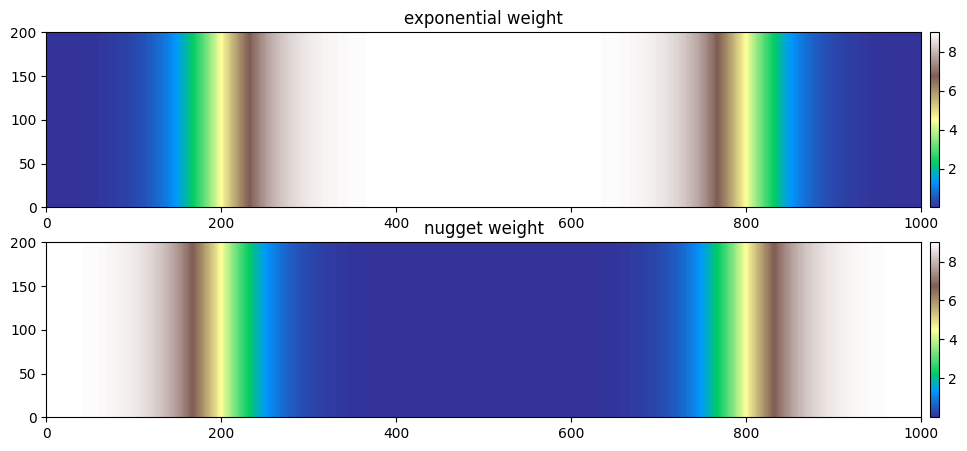

In [9]:
# Plot
# ----
# Set weight in images ...
im_exp_w = gn.img.Img(nx, 1, 1, sx, 1., 1., ox, 0., 0., nv=1, val=exp_w)
im_nug_w = gn.img.Img(nx, 1, 1, sx, 1., 1., ox, 0., 0., nv=1, val=nug_w)

# Set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D
im_exp_w.sy = .2 * im_exp_w.sx * im_exp_w.nx     
im_nug_w.sy = .2 * im_nug_w.sx * im_nug_w.nx 

# Plot
plt.subplots(2,1, figsize=(12,5), sharey=True)

plt.subplot(2,1,1)
gn.imgplot.drawImage2D(im_exp_w, cmap='terrain', title="exponential weight")

plt.subplot(2,1,2)
gn.imgplot.drawImage2D(im_nug_w, cmap='terrain', title="nugget weight")

plt.show()

### Settings - using data (optional) and probability (constant, optional)

In [10]:
if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Data
    x = [50.5, 300.1, 550.2, 849.4]  # data locations (real coordinates)
    v = [ 1., 2., 1., 3.]            # data values
    # x = None
    # v = None

    # Probability, proportion of each category
    probability = [.1, .2, .7] # should sum to 1
    # probability = None

    # Type of kriging
    method = 'simple_kriging'

else:
    # Case with ncategory = 1
    # -----------------------
    # Data
    x = [50.5, 300.1, 550.2, 849.4]  # data locations (real coordinates)
    v = [ 0., 2., 2., 0.]            # data values
    # x = None
    # v = None

    # Probability, proportion (of non-zero category)
    probability = [.7] # list of one number in the interval [0, 1]
    # probability = None

    # Type of kriging
    method = 'simple_kriging'

### Estimation of probabilities (by kriging)

In [11]:
# Computational resources
nthreads = 8

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False, # search neighborhood (unique cannot be used with non-stationarities)...
                            searchRadius=None,             
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 0.0044 sec


In [12]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [13]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nthreads = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False, # search neighborhood (unique cannot be used with non-stationarities)...
                            searchRadius=None,             
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(krig_img.val, krig_img_2.val)}")


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 0.0065 sec
Same results ? True


### Simulations

In [14]:
# Number of realizations
nreal = 1000

# Seed
seed = 321

# Computational resources
nproc = 2
nthreads_per_proc = 4

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulateIndicator: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic run complete
simulateIndicator: Geos-Classic (2 process(es)) run complete
Elapsed time: 3.2 sec


In [15]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [16]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nproc = 1
nthreads_per_proc = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(simul_img.val, simul_img_2.val)}")


simulateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
simulateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 14 sec
Same results ? True


### Plot the results

In [17]:
# Set sapcing (cell size) in y direction (1 cell in 1D) to visualize images using gn.imgplot.drawImage2D
sy = 0.2 * (simul_img.xmax() - simul_img.xmin())
simul_img.sy = sy
krig_img.sy = sy

if x is not None:
    # Set y-coordinates for conditioning data points for visualization
    y = len(x) * [simul_img.oy + 0.5*simul_img.sy]

In [18]:
# Compute proportion of each category (pixel-wise)
simul_img_prop = gn.img.imageCategProp(simul_img, category_values)

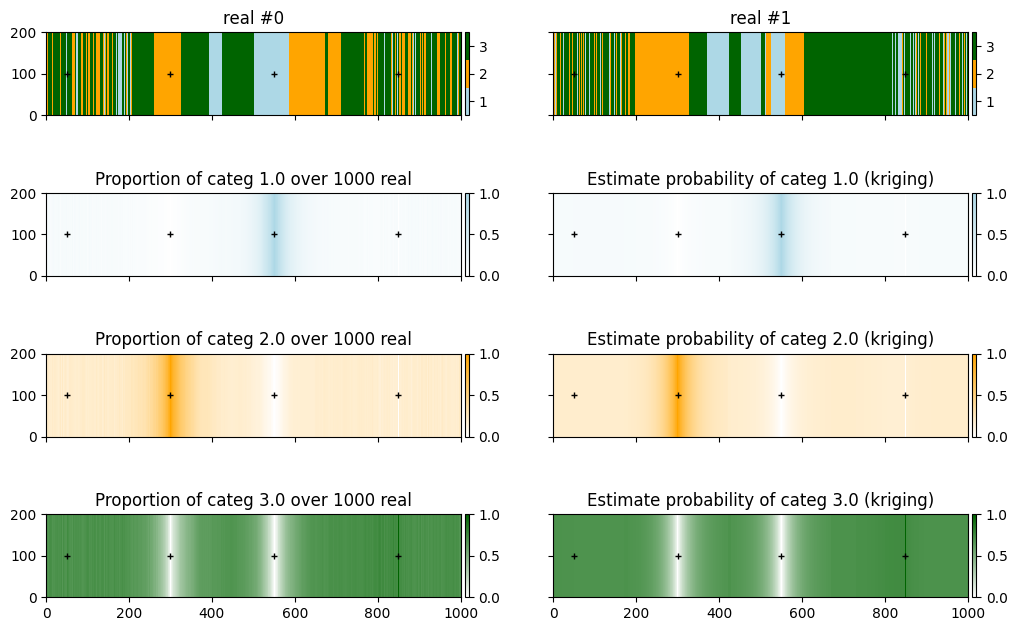

In [19]:
# Plot
plt.subplots(1+ncategory, 2, figsize=(12, 2*(1+ncategory)), sharex=True, sharey=True)

for i in range(2):
    plt.subplot(1+ncategory, 2, i+1)
    gn.imgplot.drawImage2D(simul_img, iv=i, categ=True, categVal=categVal, categCol=categCol)
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'real #{i}')

for i in range(ncategory):
    plt.subplot(1+ncategory, 2, 2*i+3)
    gn.imgplot.drawImage2D(simul_img_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Proportion of categ {categVal[i]} over {nreal} real')

    plt.subplot(1+ncategory, 2, 2*i+4)
    gn.imgplot.drawImage2D(krig_img, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Estimate probability of categ {categVal[i]} (kriging)')

plt.show()

### Check results

In [20]:
# Check data
# ----------
if x is not None:
    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
    # Check estimation
    krig_v = [krig_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    if ncategory == 1:
        print(f'Estimation: all data respected ? {np.all(np.asarray(krig_v).reshape(-1) == np.asarray([1 if vi == category_values[0] else 0 for vi in v]))}')
    else:
        print(f'Estimation: all data respected ? {np.all([np.all(krig_v[i] == np.eye(ncategory)[np.where(np.asarray(category_values) == v[i])[0][0]]) for i in range(len(x))])}')
    # Check simulation
    sim_v = [simul_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    print(f'Simulation: all data respected ? {np.all([np.all(sim_v[i] == v[i]) for i in range(len(x))])}')


Estimation: all data respected ? True
Simulation: all data respected ? True


In [21]:
# Compare probabilities
# ---------------------
if probability is not None:
    print(f'Prescribed probabilities                                    = {probability}')
    print(f'Estimation: probabilities (mean over the grid)              = {krig_img.val.mean(axis=(1,2,3))}')
    print(f'Simulation: probabilities (mean over the grid and all real.)= {[np.mean(simul_img.val == cv) for cv in category_values]}')

Prescribed probabilities                                    = [0.1, 0.2, 0.7]
Estimation: probabilities (mean over the grid)              = [0.15260573 0.23212455 0.61526972]
Simulation: probabilities (mean over the grid and all real.)= [np.float64(0.144588), np.float64(0.23767), np.float64(0.617742)]


## 2. Example - using non-stationary probabilities

### Setting probability (proportion) maps

In [22]:
# Coordinates of the center of grid cells
xg = ox + sx*(0.5+np.arange(nx))

if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Define probability maps for each category
    c = 0.9
    p1 = np.linspace(c, 0., nx)     
    p2 = c - p1
    p0 = (1. - c) * np.ones_like(p1) # 1.0 - p1 - p2 # constant map (0.1)

    probability = np.array((p0, p1, p2))

else:
    # Case with ncategory = 1
    # -----------------------
    c = 1.0
    # Define probability map for non-zero category
    probability = np.linspace(0., c, nx)



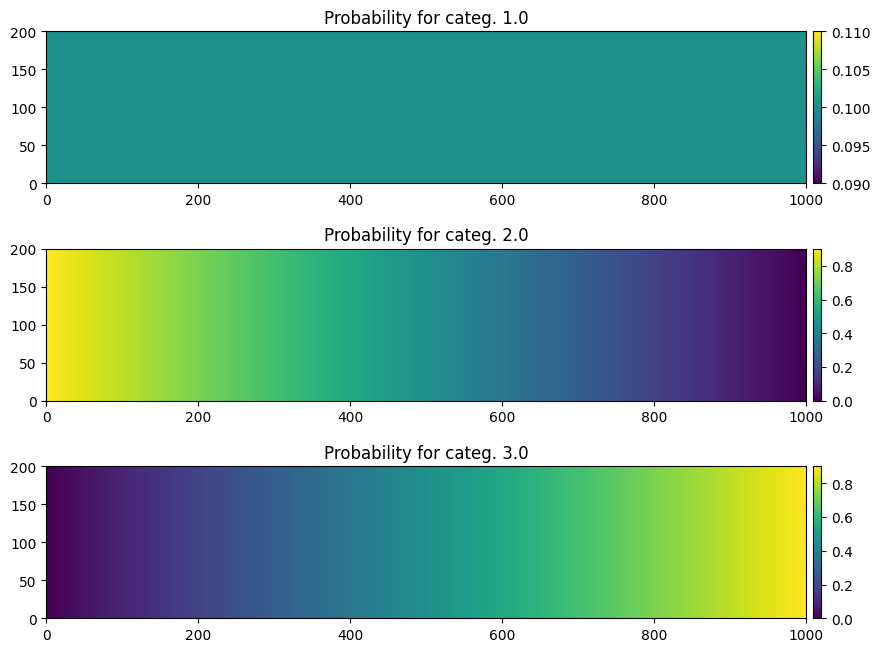

In [23]:
# Plot
# ----
# Fill image for display
probability_img = gn.img.Img(nx, 1, 1, sx, 1., 1., 0., 0., 0., nv=ncategory, val=probability)
probability_img.sy = .2 * probability_img.sx * probability_img.nx # set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D

# Display probability maps
plt.subplots(ncategory, 1, figsize=(10,8), sharey=True)

for i in range(ncategory):
    plt.subplot(ncategory, 1, 1+i)
    gn.imgplot.drawImage2D(probability_img, iv=i, title = f'Probability for categ. {categVal[i]}')

plt.show()

### Settings - using data (optional)

In [24]:
if ncategory > 1:
    # Case with ncategory > 1
    # -----------------------
    # Data
    x = [50.5, 300.1, 550.2, 849.4]  # data locations (real coordinates)
    v = [ 1., 2., 1., 3.]            # data values
    # x = None
    # v = None

    # Probability : `probability` defined above

    # Type of kriging
    method = 'simple_kriging'

else:
    # Case with ncategory = 1
    # -----------------------
    # Data
    x = [50.5, 300.1, 550.2, 849.4]  # data locations (real coordinates)
    v = [ 0., 2., 2., 0.]            # data values
    # x = None
    # v = None

    # Probability : `probability` defined above

    # Type of kriging
    method = 'simple_kriging'

### Estimation of probabilities (by kriging)

In [25]:
# Computational resources
nthreads = 8

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False, # search neighborhood (unique cannot be used with non-stationarities)...
                            searchRadius=None,             
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 0.0073 sec


In [26]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [27]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nthreads = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            use_unique_neighborhood=False, # search neighborhood (unique cannot be used with non-stationarities)...
                            searchRadius=None,             
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nthreads=nthreads,              # computational resources
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(krig_img.val, krig_img_2.val)}")


estimateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
estimateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 0.0067 sec
Same results ? True


### Simulations

In [28]:
# Number of realizations
nreal = 1000

# Seed
seed = 321

# Computational resources
nproc = 2
nthreads_per_proc = 4

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulateIndicator: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim [pid=0]: Geos-Classic run complete
simulateIndicator: Geos-Classic (2 process(es)) run complete
Elapsed time: 3.4 sec


In [29]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [30]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Equivalent, using other computational resources
# -----------------------------------------------
# Computational resources
nproc = 1
nthreads_per_proc = 1

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulateIndicator(
                            category_values,               # list of categories (required)
                            cov_model,                     # covariance model(s) (required)
                            nx, sx, ox,                    # grid geometry (nx is required)
                            x=x, v=v,                      # data
                            probability=probability,       # probability
                            cov_model_non_stationarity_list=cov_model_non_stationarity_list, # non-stationrities
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img_2 = geosclassic_output['image'] # output image

print(f"Same results ? {np.allclose(simul_img.val, simul_img_2.val)}")


simulateIndicator: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 1 thread(s)]
run_MPDSOMPGeosClassicIndicatorSim: Geos-Classic run complete
simulateIndicator: Geos-Classic (1 process) run complete
Elapsed time: 15 sec
Same results ? True


### Plot the results

In [31]:
# Set sapcing (cell size) in y direction (1 cell in 1D) to visualize images using gn.imgplot.drawImage2D
sy = 0.2 * (simul_img.xmax() - simul_img.xmin())
simul_img.sy = sy
krig_img.sy = sy

if x is not None:
    # Set y-coordinates for conditioning data points for visualization
    y = len(x) * [simul_img.oy + 0.5*simul_img.sy]

In [32]:
# Compute proportion of each category (pixel-wise)
simul_img_prop = gn.img.imageCategProp(simul_img, category_values)

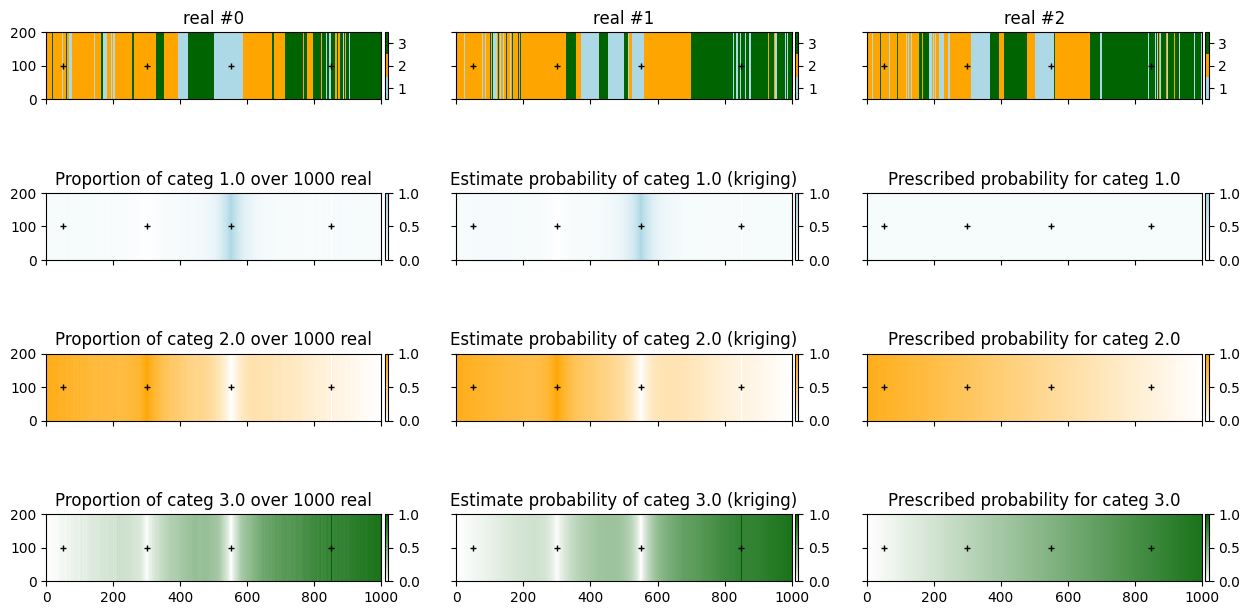

In [33]:
# Plot
plt.subplots(1+ncategory, 3, figsize=(15, (1+ncategory)*2), sharex=True, sharey=True)

for i in range(3):
    plt.subplot(1+ncategory, 3, i+1)
    gn.imgplot.drawImage2D(simul_img, iv=i, categ=True, categVal=categVal, categCol=categCol)
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'real #{i}')

for i in range(ncategory):
    plt.subplot(1+ncategory, 3, 3*i+4)
    gn.imgplot.drawImage2D(simul_img_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Proportion of categ {categVal[i]} over {nreal} real')

    plt.subplot(1+ncategory, 3, 3*i+5)
    gn.imgplot.drawImage2D(krig_img, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Estimate probability of categ {categVal[i]} (kriging)')

    plt.subplot(1+ncategory, 3, 3*i+6)
    gn.imgplot.drawImage2D(probability_img, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i])
    if x is not None:
        plt.plot(x, y, '+', c='black', markersize=5) # add conditioning point locations
    plt.title(f'Prescribed probability for categ {categVal[i]}')

plt.show()

### Check results

In [34]:
# Check data
# ----------
if x is not None:
    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk, 0, 0, sx, 1., 1., ox, 0., 0.) for xk in x] # (ix, iy, iz) for each data point
    # Check estimation
    krig_v = [krig_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    if ncategory == 1:
        print(f'Estimation: all data respected ? {np.all(np.asarray(krig_v).reshape(-1) == np.asarray([1 if vi == category_values[0] else 0 for vi in v]))}')
    else:
        print(f'Estimation: all data respected ? {np.all([np.all(krig_v[i] == np.eye(ncategory)[np.where(np.asarray(category_values) == v[i])[0][0]]) for i in range(len(x))])}')
    # Check simulation
    sim_v = [simul_img.val[:, iz, iy, ix] for ix, iy, iz in data_grid_index]
    print(f'Simulation: all data respected ? {np.all([np.all(sim_v[i] == v[i]) for i in range(len(x))])}')


Estimation: all data respected ? True
Simulation: all data respected ? True
